# Data Alignmnent 
## normalize dates

In [21]:
import pandas as pd

# Load news dataset (analyst ratings)
news_df = pd.read_csv('../assets/data/raw_analyst_ratings.csv')

# Load stock price datasets for each stock
stock_dfs = {
    'AAPL': pd.read_csv('../assets/data/AAPL_historical_data.csv'),
    'AMZN': pd.read_csv('../assets/data/AMZN_historical_data.csv'),
    'GOOG': pd.read_csv('../assets/data/GOOG_historical_data.csv'),
    'MSFT': pd.read_csv('../assets/data/MSFT_historical_data.csv'),
    'META': pd.read_csv('../assets/data/META_historical_data.csv'),
    'NVDA': pd.read_csv('../assets/data/NVDA_historical_data.csv'),
    'TSLA': pd.read_csv('../assets/data/TSLA_historical_data.csv')
}

# Normalize timestamps for news data (ensure both date and time are captured)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with NaT in the 'date' column
news_df = news_df.dropna(subset=['date'])

# Normalize timestamps for stock price data (ensure both date and time are captured)
for stock, stock_data in stock_dfs.items():
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Convert stock Date columns to timezone-aware (UTC) to match news data
for stock, stock_data in stock_dfs.items():
    if stock_data['Date'].dt.tz is None:  # Check if timezone is naive
        stock_data['Date'] = stock_data['Date'].dt.tz_localize('UTC')  # Localize to UTC
    else:
        stock_data['Date'] = stock_data['Date'].dt.tz_convert('UTC')  # Convert to UTC if already aware

# Convert news date column to UTC timezone (if it's not already)
if news_df['date'].dt.tz is None:  # Check if timezone is naive
    news_df['date'] = news_df['date'].dt.tz_localize('UTC')  # Localize to UTC
else:
    news_df['date'] = news_df['date'].dt.tz_convert('UTC')  # Convert to UTC if already aware

# Align news with stock prices
aligned_dfs = {}

for stock, stock_data in stock_dfs.items():
    # Merge the stock data with news data based on the nearest date
    aligned_news = pd.merge_asof(
        stock_data.sort_values('Date'),
        news_df.sort_values('date'),
        left_on='Date',
        right_on='date',
        direction='nearest'
    )
    aligned_dfs[stock] = aligned_news

# Handle missing data by dropping rows with missing values after the merge
for stock in aligned_dfs:
    aligned_dfs[stock] = aligned_dfs[stock].dropna()

# Example: Check the first few rows of the aligned data for AAPL
aapl_aligned_data = aligned_dfs['META']
print(aapl_aligned_data.head())


                       Date       Open       High        Low      Close  \
0 2012-12-12 00:00:00+00:00  28.000000  28.139999  27.370001  27.580000   
1 2012-12-13 00:00:00+00:00  27.590000  28.750000  27.430000  28.240000   
2 2012-12-14 00:00:00+00:00  28.180000  28.330000  26.760000  26.809999   
3 2012-12-17 00:00:00+00:00  26.770000  27.000000  26.320000  26.750000   
4 2012-12-18 00:00:00+00:00  26.959999  27.910000  26.900000  27.709999   

   Adj Close    Volume  Dividends  Stock Splits  Unnamed: 0  \
0  27.523441  46704200        0.0           0.0     1053596   
1  28.182087  81051600        0.0           0.0      721913   
2  26.755020  91631600        0.0           0.0      429402   
3  26.695143  57742500        0.0           0.0      147167   
4  27.653173  60512900        0.0           0.0      147167   

                                        headline  \
0  ProShares to List Merger ETF on BATS Exchange   
1  These ETFs Are Awash in 2013 Takeover Targets   
2   Apple to b

# Sentiment Analysis:

In [2]:
from textblob import TextBlob

# Load data from a CSV file
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Ensure the dataset has a 'headline' column
if 'headline' not in df.columns:
    raise ValueError("The dataset must contain a 'headline' column.")

# Perform sentiment analysis
def analyze_sentiment(headline):
    analysis = TextBlob(headline)
    polarity = analysis.polarity  # Sentiment polarity: -1 (negative) to +1 (positive)
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment analysis function to the headlines
df['sentiment'] = df['headline'].apply(analyze_sentiment)

# Count the number of headlines by sentiment
sentiment_counts = df['sentiment'].value_counts()

# Print results
print("Sentiment Analysis Results:")
print(sentiment_counts)


Sentiment Analysis Results:
sentiment
Neutral     934914
Positive    341178
Negative    131236
Name: count, dtype: int64


# Daily Stock Returns: 

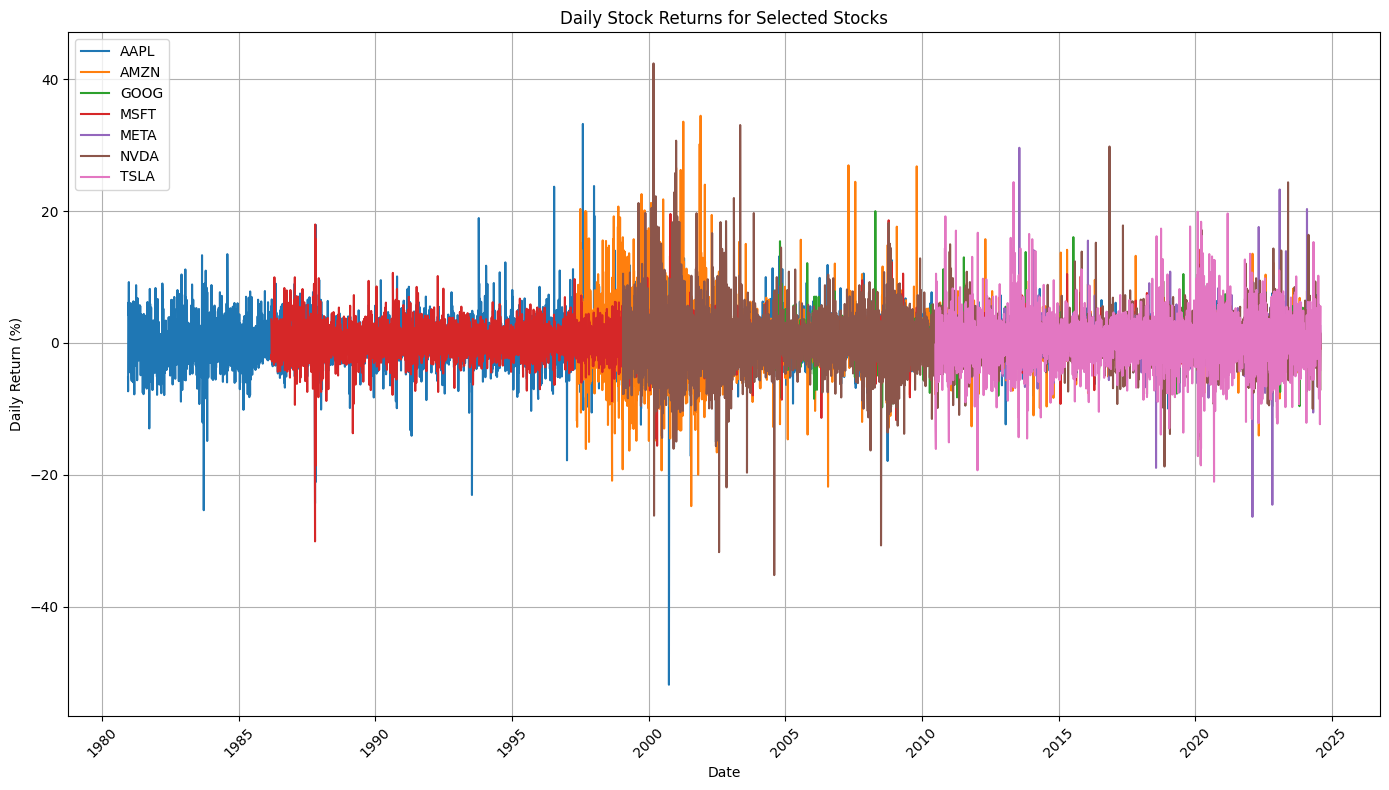

               Close  Daily_Return
Date                              
1980-12-12  0.128348           NaN
1980-12-15  0.121652     -5.217061
1980-12-16  0.112723     -7.339788
1980-12-17  0.115513      2.475091
1980-12-18  0.118862      2.899246


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# List of stock filenames
stock_files = {
    'AAPL': '../assets/data/AAPL_historical_data.csv',
    'AMZN': '../assets/data/AMZN_historical_data.csv',
    'GOOG': '../assets/data/GOOG_historical_data.csv',
    'MSFT': '../assets/data/MSFT_historical_data.csv',
    'META': '../assets/data/META_historical_data.csv',
    'NVDA': '../assets/data/NVDA_historical_data.csv',
    'TSLA': '../assets/data/TSLA_historical_data.csv'
}

# Dictionary to store daily returns for each stock
daily_returns = {}

# Loop through each stock and calculate the daily returns
for stock, file_path in stock_files.items():
    # Load stock data
    stock_data = pd.read_csv(file_path)

    # Ensure the 'Date' column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Set 'Date' as the index
    stock_data.set_index('Date', inplace=True)

    # Calculate daily returns based on the 'Close' price (percentage change)
    stock_data['Daily_Return'] = stock_data['Close'].pct_change() * 100

    # Store the daily returns in the dictionary
    daily_returns[stock] = stock_data[['Close', 'Daily_Return']]

    # Optionally, save the results to a new CSV file
    stock_data.to_csv(f'../assets/data/{stock}_with_daily_returns.csv')

    # Plotting the daily returns for each stock
plt.figure(figsize=(14, 8))

# Loop through the dictionary and plot daily returns for each stock
for stock, data in daily_returns.items():
    plt.plot(data.index, data['Daily_Return'], label=stock)


# Adding title and labels
plt.title('Daily Stock Returns for Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Example: Print the first few rows of the daily returns for AAPL
print(daily_returns['AAPL'].head())


# Aggregate Sentiments:

                       date  sentiment_score
0 2011-04-28 01:01:48+00:00         0.000000
1 2011-04-28 17:49:29+00:00         0.136364
2 2011-04-28 19:00:36+00:00         0.000000
3 2011-04-29 17:47:06+00:00        -0.166667
4 2011-04-29 20:11:05+00:00         0.500000


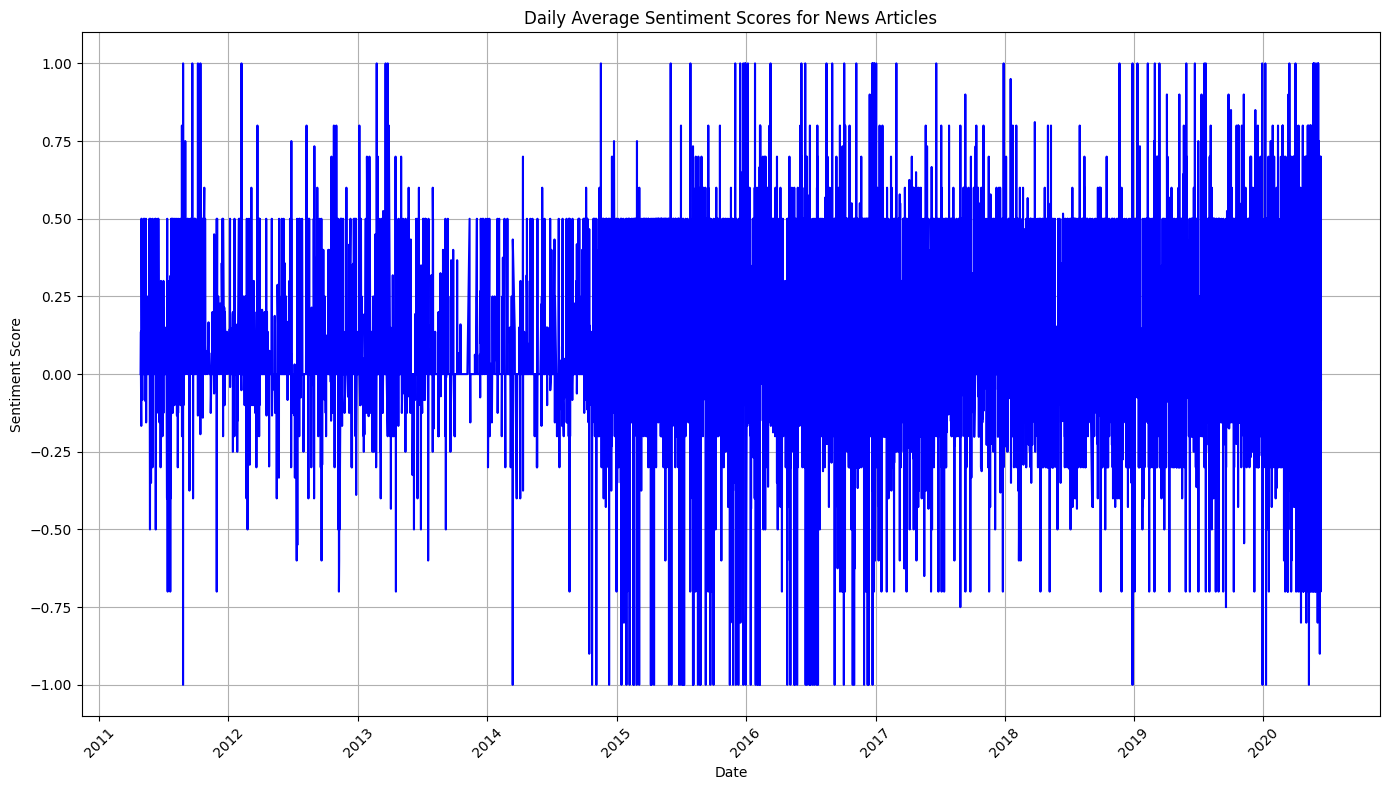

In [4]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Sample news data with 'date' and 'sentiment_score' columns
news_data = pd.read_csv('../assets/data/raw_analyst_ratings.csv')

# Ensure the 'date' column is in datetime format
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')


# Function to calculate sentiment polarity using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))  # Ensure text is in string format
    return blob.sentiment.polarity  # You can also use blob.sentiment.subjectivity if needed

# Calculate sentiment scores for each article
news_data['sentiment_score'] = news_data['headline'].apply(get_sentiment)

# Check if timezone is naive and localize or convert to UTC
if news_data['date'].dt.tz is None:  # Check if timezone is naive
    news_data['date'] = news_data['date'].dt.tz_localize('UTC')  # Localize to UTC
else:
    news_data['date'] = news_data['date'].dt.tz_convert('UTC')

# Calculate daily average sentiment scores by grouping by 'date'
daily_sentiment = news_data.groupby('date')['sentiment_score'].mean().reset_index()

# Display the first few rows of the aggregated sentiment scores
print(daily_sentiment.head())

# Optionally, save the aggregated data to a CSV file
daily_sentiment.to_csv('../assets/data/daily_sentiment_scores.csv', index=False)

# Plotting the daily sentiment scores
plt.figure(figsize=(14, 8))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_score'], label='Daily Average Sentiment', color='blue')

# Adding title and labels
plt.title('Daily Average Sentiment Scores for News Articles')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# normalized data between daily return and sentiment score for easily computation of correlation

In [19]:
import pandas as pd

# Load news dataset (analyst ratings)
news_df = pd.read_csv('../assets/data/daily_sentiment_scores.csv')

# Load stock price datasets for each stock
stock_dfs = {
    'AAPL': pd.read_csv('../assets/data/AAPL_with_daily_returns.csv'),
    'AMZN': pd.read_csv('../assets/data/AMZN_with_daily_returns.csv'),
    'GOOG': pd.read_csv('../assets/data/GOOG_with_daily_returns.csv'),
    'MSFT': pd.read_csv('../assets/data/MSFT_with_daily_returns.csv'),
    'META': pd.read_csv('../assets/data/META_with_daily_returns.csv'),
    'NVDA': pd.read_csv('../assets/data/NVDA_with_daily_returns.csv'),
    'TSLA': pd.read_csv('../assets/data/TSLA_with_daily_returns.csv')
}

# Normalize timestamps for news data (ensure both date and time are captured)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with NaT in the 'date' column
news_df = news_df.dropna(subset=['date'])

# Normalize timestamps for stock price data (ensure both date and time are captured)
for stock, stock_data in stock_dfs.items():
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Convert stock Date columns to timezone-aware (UTC) to match news data
for stock, stock_data in stock_dfs.items():
    if stock_data['Date'].dt.tz is None:  # Check if timezone is naive
        stock_data['Date'] = stock_data['Date'].dt.tz_localize('UTC')  # Localize to UTC
    else:
        stock_data['Date'] = stock_data['Date'].dt.tz_convert('UTC')  # Convert to UTC if already aware

# Convert news date column to UTC timezone (if it's not already)
if news_df['date'].dt.tz is None:  # Check if timezone is naive
    news_df['date'] = news_df['date'].dt.tz_localize('UTC')  # Localize to UTC
else:
    news_df['date'] = news_df['date'].dt.tz_convert('UTC')  # Convert to UTC if already aware

# Align news with stock prices
aligned_dfs = {}

for stock, stock_data in stock_dfs.items():
    # Merge the stock data with news data based on the nearest date
    aligned_news = pd.merge_asof(
        stock_data.sort_values('Date'),
        news_df.sort_values('date'),
        left_on='Date',
        right_on='date',
        direction='nearest'
    )
    aligned_dfs[stock] = aligned_news

# Handle missing data by dropping rows with missing values after the merge
for stock in aligned_dfs:
    aligned_dfs[stock] = aligned_dfs[stock].dropna()

    # Optionally, you can save the aligned data to CSV files

for stock, aligned_data in aligned_dfs.items():
    output_file = f'../assets/data/{stock}_merged.csv'
    aligned_data.to_csv(output_file, index=False)
    print(f"Saved merged data for {stock} to {output_file}")
# Example: Check the first few rows of the aligned data for AAPL
aapl_aligned_data = aligned_dfs['AAPL']
print(aapl_aligned_data.head())


Saved merged data for AAPL to ../assets/data/AAPL_merged.csv
Saved merged data for AMZN to ../assets/data/AMZN_merged.csv
Saved merged data for GOOG to ../assets/data/GOOG_merged.csv
Saved merged data for MSFT to ../assets/data/MSFT_merged.csv
Saved merged data for META to ../assets/data/META_merged.csv
Saved merged data for NVDA to ../assets/data/NVDA_merged.csv
Saved merged data for TSLA to ../assets/data/TSLA_merged.csv
                       Date      Open      High       Low     Close  \
1 1980-12-15 00:00:00+00:00  0.122210  0.122210  0.121652  0.121652   
2 1980-12-16 00:00:00+00:00  0.113281  0.113281  0.112723  0.112723   
3 1980-12-17 00:00:00+00:00  0.115513  0.116071  0.115513  0.115513   
4 1980-12-18 00:00:00+00:00  0.118862  0.119420  0.118862  0.118862   
5 1980-12-19 00:00:00+00:00  0.126116  0.126674  0.126116  0.126116   

   Adj Close     Volume  Dividends  Stock Splits  Daily_Return  \
1   0.093781  175884800        0.0           0.0     -5.217061   
2   0.086898  

# Correlation

In [20]:
import numpy as np
import pandas as pd
import os

def calculate_pearson_correlation_from_merged_file(merged_file_path):
    """
    Calculates the Pearson correlation coefficient between daily sentiment scores 
    and stock daily returns from a single merged file.

    Parameters:
        merged_file_path (str): Path to the merged CSV file.

    Returns:
        float: Pearson correlation coefficient.
    """
    # Load the merged data
    merged_df = pd.read_csv(merged_file_path)

    # Standardize column names
    merged_df.columns = merged_df.columns.str.strip().str.lower()

    # Ensure required columns exist
    if not {'sentiment_score', 'daily_return'}.issubset(merged_df.columns):
        raise ValueError(f"File {merged_file_path} must have 'sentiment_score' and 'daily_return' columns.")
    
    # Drop rows with missing data
    merged_df = merged_df.dropna(subset=['sentiment_score', 'daily_return'])

    # Debugging: Check the number of valid rows
    print(f"Total rows after dropping missing data in {merged_file_path}: {len(merged_df)}")

    # Ensure sufficient data points
    if len(merged_df) < 2:
        raise ValueError(f"Not enough data points for correlation calculation in {merged_file_path}.")
    
    # Extract data for correlation
    sentiment_scores = merged_df['sentiment_score'].tolist()
    stock_returns = merged_df['daily_return'].tolist()

    # Calculate Pearson correlation coefficient
    correlation = np.corrcoef(sentiment_scores, stock_returns)[0, 1]

    return correlation

# Path to the directory where the merged stock files are stored
merged_data_directory = '../assets/data/'

# List all CSV files in the directory that start with the stock name and end with '_merged.csv'
merged_files = [f for f in os.listdir(merged_data_directory) if f.endswith('_merged.csv')]

# Calculate Pearson correlation for each stock
for merged_file in merged_files:
    merged_file_path = os.path.join(merged_data_directory, merged_file)
    
    try:
        pearson_corr = calculate_pearson_correlation_from_merged_file(merged_file_path)
        print(f"Pearson Correlation Coefficient for {merged_file}: {pearson_corr}")
    except Exception as e:
        print(f"Error processing {merged_file}: {e}")


Total rows after dropping missing data in ../assets/data/NVDA_merged.csv: 6420
Pearson Correlation Coefficient for NVDA_merged.csv: -0.0031275917625069255
Total rows after dropping missing data in ../assets/data/GOOG_merged.csv: 5019
Pearson Correlation Coefficient for GOOG_merged.csv: 0.0014329625630151168
Total rows after dropping missing data in ../assets/data/AAPL_merged.csv: 10997
Pearson Correlation Coefficient for AAPL_merged.csv: -0.005824893410032895
Total rows after dropping missing data in ../assets/data/AMZN_merged.csv: 6845
Pearson Correlation Coefficient for AMZN_merged.csv: -0.002207884687214358
Total rows after dropping missing data in ../assets/data/META_merged.csv: 2925
Pearson Correlation Coefficient for META_merged.csv: -0.0022751516495962873
Total rows after dropping missing data in ../assets/data/MSFT_merged.csv: 9671
Pearson Correlation Coefficient for MSFT_merged.csv: -0.004191274606370307
Total rows after dropping missing data in ../assets/data/TSLA_merged.csv: